## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
    * Normalizing
* Split training and test datasets
* Build the model
* Test the model
* Conclusions

### Import Libraries

In [65]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data and Analysis

In [66]:
data = pd.read_csv('eth-eur.csv')
data.iloc[random.randint(0, data.shape[0])]

snapped_at      2017-10-30 00:00:00 UTC
price                           262.934
market_cap                  2.50904e+10
total_volume                2.10903e+08
Name: 814, dtype: object

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 4 columns):
snapped_at      896 non-null object
price           896 non-null float64
market_cap      895 non-null float64
total_volume    896 non-null float64
dtypes: float64(3), object(1)
memory usage: 28.1+ KB


In [68]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [69]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

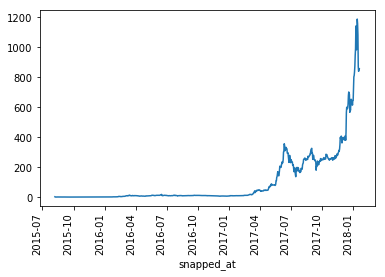

In [70]:
data.price.plot(rot=90)

In [71]:
data.head(24)

,price,market_cap,total_volume
snapped_at,,,
2015-08-07,2.580213,0.000000e+00,8.257608e+04
2015-08-08,1.175306,7.095505e+07,3.250759e+05
2015-08-10,0.624116,3.772033e+07,3.634980e+05
2015-08-11,0.966607,5.844581e+07,1.375588e+06
2015-08-12,1.126292,6.813006e+07,1.858814e+06
2015-08-13,1.636673,9.904778e+07,3.927292e+06
2015-08-14,1.643557,9.951063e+07,3.920484e+06
2015-08-15,1.505036,9.116528e+07,2.269451e+06
2015-08-16,1.329391,8.055977e+07,2.730304e+06


### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [72]:
#check
'2015-08-09 00:00:00' in data.index

False

In [73]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

#### Find NaN and Fix it

In [74]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [75]:
#check
data.loc['2015-08-09 00:00:00']

price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [76]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

In [92]:
new_column = 'closed_price'

for idx in data.index:
    dayloc = data.index.get_loc(idx)

    #we can not know the closed price of last day, so drop from data
    if dayloc == len(data.index)-1:
        data.drop(idx, inplace=True)
    else:
        data.loc[idx][new_column] = data.iloc[dayloc+1].price

data.tail(5)

,price,market_cap,total_volume,closed_price
2018-01-14,1156.066226,1.121197e+11,2.272643e+09,1084.204749
2018-01-15,1084.204749,1.051702e+11,1.988101e+09,871.038635
2018-01-16,871.038635,8.450991e+10,4.236883e+09,838.829188
2018-01-17,838.829188,8.140486e+10,4.516756e+09,846.823344
2018-01-18,846.823344,8.219815e+10,2.632209e+09,856.639434


__Note: rethink. Is it necessary to drop the last day? Maintain with NaN as closed price.__

#### Normalizing

In [93]:
#Scale the data
scaler = StandardScaler()

data[data.columns] = scaler.fit_transform(data)
data.describe()

,price,market_cap,total_volume,closed_price
count,8.960000e+02,8.960000e+02,896.000000,8.960000e+02
mean,6.344132e-17,3.172066e-17,0.000000,-6.344132e-17
std,1.000559e+00,1.000559e+00,1.000559,1.000559e+00
min,-5.504746e-01,-5.418937e-01,-0.409489,-5.505387e-01
25%,-5.134940e-01,-5.077924e-01,-0.401567,-5.137356e-01
50%,-4.941983e-01,-4.908084e-01,-0.380746,-4.946315e-01
75%,4.031644e-01,3.820253e-01,-0.013836,3.999296e-01
max,5.962246e+00,6.014481e+00,9.400514,5.901625e+00


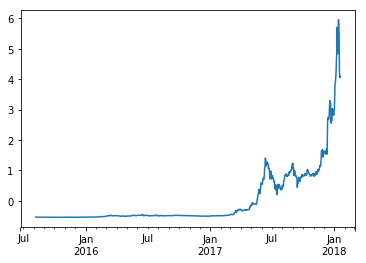

In [94]:
data.price.plot()